In [ ]:
# importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud, STOPWORDS
import re, string, unicodedata
import nltk
#import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
string.punctuation
nltk.download('omw-1.4')
from nltk.tokenize import TweetTokenizer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline
sns.set()
# reading data

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# reading data
path = 'drive/MyDrive/Moramsc/datasets/netflix_india_shows_and_movies.csv'

original_df = pd.read_csv(path,index_col='showid')
df = original_df.copy()

In [ ]:
# Handling the missing values
df[['hook_text','mood_tag','actors','director','audio','subtitles','production_country']] = df[['hook_text','mood_tag','actors','director','audio','subtitles','production_country']].fillna('Unknown')
df[['similar_titles_id']] = df[['similar_titles_id']].fillna(-1)
df.drop('creator', axis=1, inplace=True)
df.drop('release_year', axis=1, inplace=True)

In [ ]:
# Choosing the primary country and primary genre to simplify the analysis
df['audio'] = df['audio'].apply(lambda x: x.split(';')[0])
df['subtitles'] = df['subtitles'].apply(lambda x: x.split(';')[0])
df['mood_tag'] = df['mood_tag'].apply(lambda x: x.split(';')[0])
df['tags'] = df['tags'].apply(lambda x: x.split(';')[0])

In [ ]:
# Splitting the duration column, and changing the datatype to integer
df['duration'] = df['duration'].astype(str)
df['duration'] = df['duration'].apply(lambda x: float(x.split()[0]))

In [ ]:
# Typecasting release_date from string to datetime
df["release_date"] = pd.to_datetime(df['release_date'])

In [ ]:
# Adding new attributes month and year of date added

df['release_month'] = df['release_date'].dt.month
df['release_year'] = df['release_date'].dt.year
df.drop('release_date', axis=1, inplace=True)

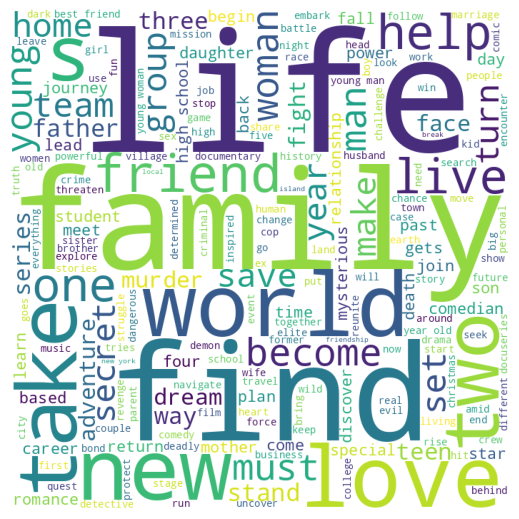

In [ ]:
# Building a wordcloud for the movie descriptions
comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df.description.values:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 700, height = 700,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)


# plot the WordCloud image
plt.figure(figsize = (10,5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

In [ ]:
# Using the original dataset for clustering since
# it does not require handling missing values
df1 = original_df.copy()
df1.fillna('',inplace=True)
# Combining all the clustering attributes into a single column

df1['clustering_attributes'] = (df1['director'] + ' ' +
                                df1['hook_text'] +' ' +
                                df1['production_country'] +' ' +
                                df1['audio'] +' ' +
                                df1['subtitles'] +' ' +
                                df1['tags'] +' ' +
                                df1['actors'] +' ' +
                                df1['mood_tag'] +' ' +
                                df1['description'])

In [ ]:
# function to remove non-ascii characters

def remove_non_ascii(words):
    """Function to remove non-ASCII characters"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words
# remove non-ascii characters
df1['clustering_attributes'] = remove_non_ascii(df1['clustering_attributes'])

In [ ]:
# extracting the stopwords from nltk library
import nltk
from nltk.corpus import stopwords
sw = stopwords.words('english')
# displaying the stopwords
np.array(sw)
# function to remove stop words
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [ ]:
# Removing stop words
df1['clustering_attributes'] = df1['clustering_attributes'].apply(stopwords)

In [ ]:
# function to remove punctuations
def remove_punctuation(text):
    '''a function for removing punctuation'''
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)
# Removing punctuation marks
df1['clustering_attributes'] = df1['clustering_attributes'].apply(remove_punctuation)

In [ ]:
# nction to lemmatize the corpus
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas
# Lemmatization
df1['clustering_attributes'] = lemmatize_verbs(df1['clustering_attributes'])

In [ ]:
tokenizer = TweetTokenizer()
df1['clustering_attributes'] = df1['clustering_attributes'].apply(lambda x: tokenizer.tokenize(x))

In [ ]:
# clustering tokens saved in a variable
clustering_data = df1['clustering_attributes']
# Tokenization
def identity_tokenizer(text):
    return text

# Using TFIDF vectorizer to vectorize the corpus
# max features = 20000 to prevent system from crashing
tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False,max_features = 20000)
X = tfidf.fit_transform(clustering_data)

In [ ]:
X
# Shape of X
X.shape
# data type of vector
type(X)
# convert X into array form for clustering
X = X.toarray()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

In [ ]:
# Encode categorical features using one-hot encoding
categorical_features = ['rating', 'genre']
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_features = encoder.fit_transform(df[categorical_features])

# Scale numeric features
numeric_features = ['duration', 'release_month', 'release_year']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[numeric_features])

# Combine preprocessed features
preprocessed_features = pd.DataFrame(data=scaled_features, columns=numeric_features)
preprocessed_features = pd.concat([preprocessed_features, pd.DataFrame(data=encoded_features)], axis=1)
preprocessed_features = pd.concat([preprocessed_features, pd.DataFrame(data=X)], axis=1)

In [ ]:
preprocessed_features.columns = preprocessed_features.columns.astype(str)

In [ ]:
# reducing the dimensions to 3000 using pca
pca = PCA(n_components=3000,random_state=42)
pca.fit(preprocessed_features)
# transformed features
x_pca = pca.transform(preprocessed_features)
# shape of transformed vectors
x_pca.shape

(6666, 3000)

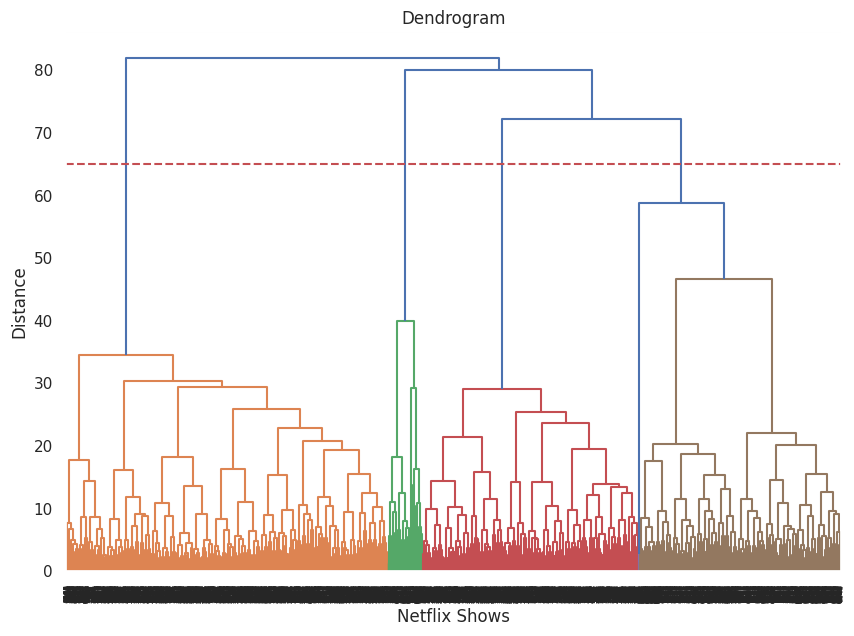

In [ ]:
# Building a dendogram to decide on the number of clusters
plt.figure(figsize=(10, 7))
dend = shc.dendrogram(shc.linkage(x_pca, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Netflix Shows')
plt.ylabel('Distance')
plt.axhline(y= 65, color='r', linestyle='--')

In [ ]:
# Fitting hierarchical clustering model
hierarchical = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
hierarchical.fit_predict(x_pca)

array([3, 3, 3, ..., 0, 0, 0])

In [ ]:
# Adding a kmeans cluster number attribute
df1['hierarchical_cluster'] = hierarchical.labels_

In [ ]:
from sklearn.metrics import silhouette_score

# Assuming you have already fitted the k-medoids model to the data
silhouette_avg = silhouette_score(x_pca, hierarchical.labels_)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.11017342717881905


In [ ]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(preprocessed_features, hierarchical.labels_)
print("Davies-Bouldin Index:", db_index)

Davies-Bouldin Index: 2.0762185931309487


In [ ]:
from sklearn.metrics import calinski_harabasz_score

ch_index = calinski_harabasz_score(preprocessed_features,hierarchical.labels_)
print("Calinski-Harabasz Index:", ch_index)


Calinski-Harabasz Index: 774.3994722707832


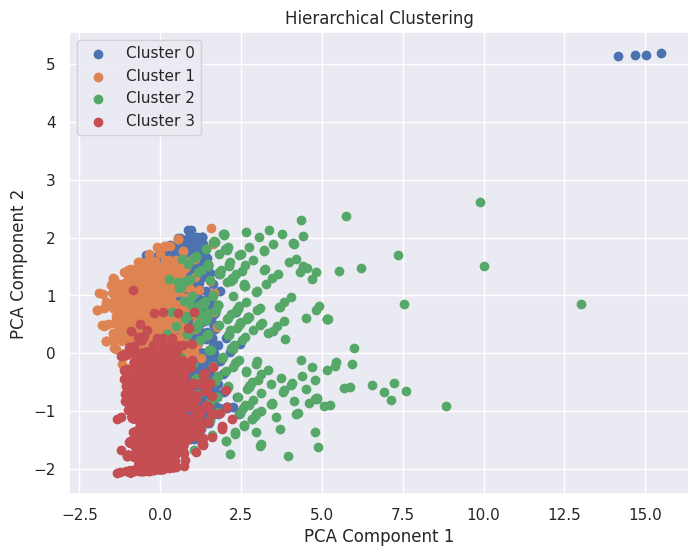

In [ ]:
import matplotlib.pyplot as plt

# Plotting the clusters
plt.figure(figsize=(8, 6))

# Iterate over each unique cluster label
for cluster_label in set(hierarchical.labels_):
    # Select data points belonging to the current cluster
    cluster_data = x_pca[hierarchical.labels_ == cluster_label]

    # Plot the data points for the current cluster
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster_label}')

# Add labels and title
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Hierarchical Clustering')

# Add legend
plt.legend()

# Show plot
plt.show()


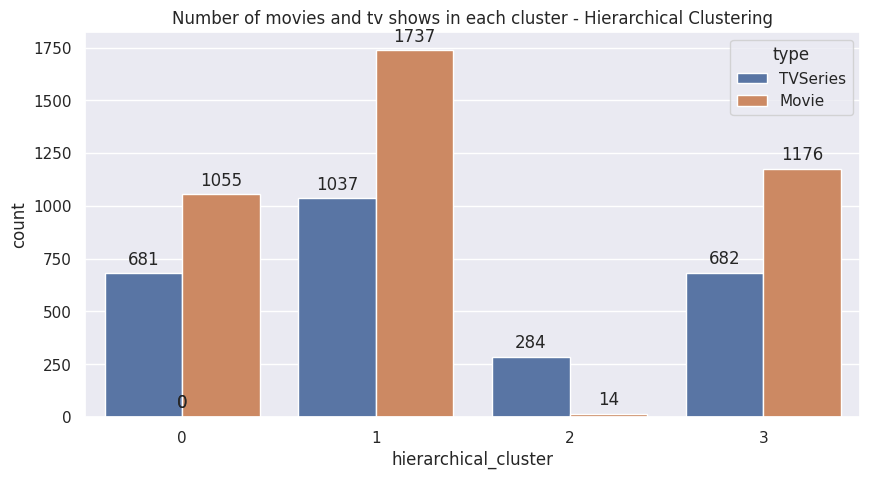

In [ ]:
# Number of movies and tv shows in each cluster
plt.figure(figsize=(10,5))
q = sns.countplot(x='hierarchical_cluster',data=df1, hue='type')
plt.title('Number of movies and tv shows in each cluster - Hierarchical Clustering')
for i in q.patches:
  q.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [ ]:
def hierarchical_worldcloud(cluster_num):
  comment_words = ''
  stopwords = set(STOPWORDS)

  # iterate through the csv file
  for val in df1[df1['hierarchical_cluster']==cluster_num].description.values:

      # typecaste each val to string
      val = str(val)

      # split the value
      tokens = val.split()

      # Converts each token into lowercase
      for i in range(len(tokens)):
          tokens[i] = tokens[i].lower()

      comment_words += " ".join(tokens)+" "

  wordcloud = WordCloud(width = 700, height = 700,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)


 # plot the WordCloud image
  plt.figure(figsize = (10,5), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

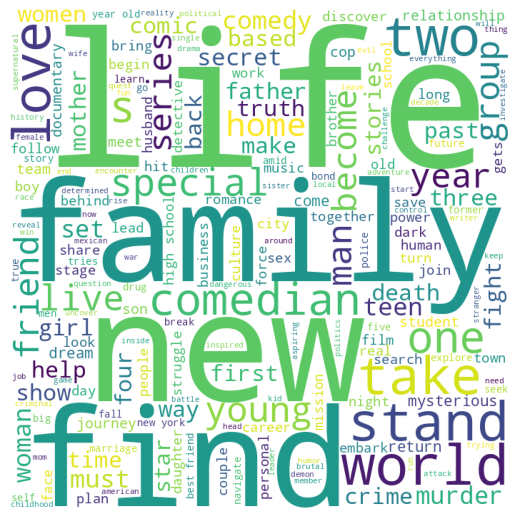

In [ ]:
# Wordcloud for cluster 0
hierarchical_worldcloud(0)

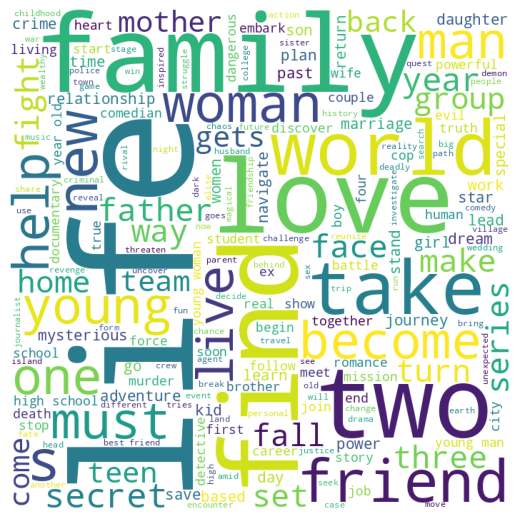

In [ ]:
# Wordcloud for cluster 0
hierarchical_worldcloud(3)